In [73]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time 

import progressbar
from progressbar import FormatLabel, Percentage, Bar, ETA


from data_loader import DataLoader
#import viewer functions
from dataViewer import plotTraj, animatePreview, animateLoc, animateTraj


%matplotlib inline
%load_ext autoreload
%autoreload 2

dtype = torch.float
device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
FPS = 16

PATH = "data/converted/"
PATH2 = "data/CSV/"
fname = "ao-360-400_combine"

#PATH_1 = "test.hd5"
#PATH_1 = "test.csv"

#ds = DataLoader(PATH + fname + ".txt")
ds = DataLoader(PATH2 + fname + "_small" + ".csv")
ds.load()

print("Persons: ", ds.data.p.max())
print("Frame maximum :", ds.data.f.max() )



Persons:  49
Frame maximum : 574


In [42]:
#ds.save("data/CSV/" + fname + "_small")

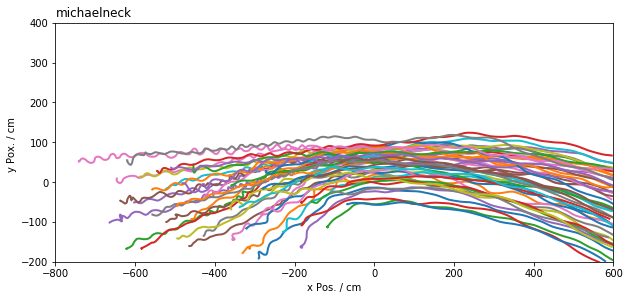

In [56]:
plotTraj(ds, boundaries=[-800, 600, -200, 400], title="michaelneck", save=False)

In [59]:
animatePreview(ds, boundaries=[-800, 600, -200, 400], step=10)

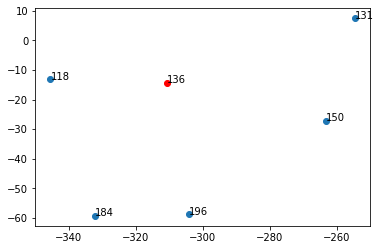

In [34]:
pids, pvals = ds.frame_nn(f_id = 310, p_id=136, nn=5, ret_vel=False, fill=True, mode="zero", use_roi=False, 
              include_origin=True, ret_full=False, box=((-800, -200), (600,400)), x_pad=0, y_pad=0)

plt.figure()
plt.scatter(pvals[0,0], pvals[0,1], color="red")
plt.scatter(pvals[1:,0], pvals[1:,1])

for (i, xy) in zip(pids, pvals):
    plt.annotate("{}".format(i), xy=xy)
plt.show()

In [49]:
train_id, trajectories = ds.get_trajectories(number_nei, ret_vel=True, fill=True, mode="zero", omit_no_neighbors=False, 
                                             use_roi=False, box=((-800, 400), (600,-200)), x_pad=0, y_pad=0,)

100% (49 of 49) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


In [72]:
#f_x = ds.flip_x
train, val, test = ds.get_train_data(number_nei, shuffle=False, mode="zero", split=(80,20,0))

100% (49 of 49) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


loaded 49 trajectories
with augmentation 49 trajectories
extracted 11427 steps


In [63]:
t_input, t_truth = train

In [79]:
t_i = torch.from_numpy(t_input).to(device)
t_t = torch.from_numpy(t_truth).to(device)

# Define Model

In [85]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Hyper-parameters 
number_nei = 5

input_size = (number_nei+1)*4
hidden_size = 500
output_size = 2
num_epochs = 2
learning_rate = 1e-4


# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = NeuralNet(input_size, hidden_size, output_size).to(device)

In [86]:
#loss and optimizer
loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [87]:
# Train the model
for epoch in range(num_epochs):
    print("epoch: {}".format(epoch))
    pbar = progressbar.ProgressBar(maxval=len(t_i))
    pbar.start()
    for i, (ti, tt) in enumerate(zip(t_i, t_t)):
        # Forward pass
        pred = model(ti)
        loss = loss_fn(pred, tt)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i%10:
            pbar.update(i)
    pbar.finish()

  0% (48 of 6856) |                      | Elapsed Time: 0:00:00 ETA:   0:00:14

epoch: 0


100% (6856 of 6856) |####################| Elapsed Time: 0:00:06 Time:  0:00:06
  2% (174 of 6856) |                     | Elapsed Time: 0:00:00 ETA:   0:00:09

epoch: 1


100% (6856 of 6856) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


In [ ]:
# save the model
torch.save(model.state_dict(), "data/model.dat")

In [184]:
da = DataLoader(None)
da.copy(ds)

print(da.persons)

49


In [185]:
id_s, trajs = da.get_trajectories(number_nei, ret_vel=True, fill=True, mode="zero", omit_no_neighbors=False, 
                                             use_roi=False, box=((-800, 400), (600,-200)), x_pad=0, y_pad=0,)

100% (49 of 49) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


# Simulate 1 Trajectory

In [186]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    id = 18

    j, traj = id_s[id], trajs[id]

    print("person: {}".format(j))

    for i in range(len(traj)-1):

        x_sim = torch.from_numpy(traj[i]).to(device)
        y_sim = model(x_sim)

        v_sim = (y_sim[:2]-x_sim[:2])/FPS
        traj[i+1, :2] = y_sim.cpu().detach().numpy()
        traj[i+1, 2:4] = v_sim.cpu().detach().numpy()

    frames, pos_vel =da.person(j) 

    da.replace_person(id_s[id],frames,  traj[:,:2])

person: 19


# Simulate All Trajectories

In [176]:
db = DataLoader(None)
pers, init_val = ds.frame(30)
frames = np.arange(30,100)

for (p_id, init) in zip(pers, init_val):
    pos = init[:2]
    vel = init[2:]
    db.append_person(id=p_id, frame=np.array([30]), traj=np.array([pos]), vel=np.array([vel]))

In [177]:
with torch.no_grad():
    pbar = progressbar.ProgressBar(maxval=len(frames))
    pbar.start()
    for i, frame in enumerate(frames):
        pbar.update(i)
        for per in pers:
            _, _, traj, _ = db.frame_nn(frame, per, number_nei, ret_vel=True, fill=True, mode="zero", use_roi=False, 
                                        ret_full=True, include_origin=True, box=((-800, 400), (600,-200)), x_pad=0, y_pad=0,)
            traj = traj.ravel().astype(np.float32)
            x_sim = torch.from_numpy(traj).to(device)
            y_sim = model(x_sim)

            v_sim = (y_sim[:2]-x_sim[:2])/FPS
            out = np.zeros(4)
            out[:2] = y_sim.cpu().detach().numpy()
            out[2:4] = v_sim.cpu().detach().numpy()

            frames, trajs =db.person(per) 
            db.replace_person(per ,np.append(frames, frame+1),  np.append(trajs[:,:2], out[:2].reshape(1,2), axis=0), np.append(trajs[:,2:], out[2:4].reshape(1,2), axis=0))
            
    pbar.finish()   

100% (70 of 70) |########################| Elapsed Time: 0:00:26 Time:  0:00:26


In [187]:
animatePreview(da, boundaries=[-800, 600, -200, 400], step=10)

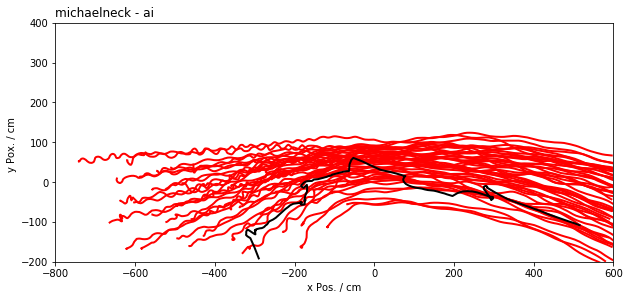

In [112]:
plotTraj(da, boundaries=[-800, 600, -200, 400], ai = [id_s[id]], title="michaelneck - ai", save=False)

In [178]:
ani = animateLoc(da, frame_start=int(da.data['f'].min()), frame_stop=int(da.data['f'].max()), ai=[id_s[id]], 
                 boundaries=[-800, 600, -200, 400], step=5, fps=16, title="michaelneck", save=False)
ani

In [105]:
da.data['f'].min()

14.0